# **Skin Cancer Detection**
Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

The dataset is taken from the ISIC (International Skin Image Collaboration) Archive. It consists of 1800 pictures of benign moles and 1497 pictures of malignant classified moles. The pictures have all been resized to low resolution (224x224x3) RGB. The task of this kernel is to create a model, which can classify a mole visually into benign and malignant. 

# importing Essential Libraries:

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense,Dropout

### Global valuable 

In [10]:
IMG_DIMEN = 224  # (W,h)
N_COLORS = 3    #n_colors

# read the data as matrix

In [11]:
def read_data(dir_path):
    X = []
    y = []
    y_map = {'benign': 0, 'malignant': 1}
    for class_name in y_map.keys():
        subdir_path = os.path.join(dir_path, class_name)
        filenames = os.listdir(subdir_path)
        for fname in tqdm(filenames):
            if fname.endswith('.jpg'):
                img_path = os.path.join(subdir_path, fname)
                img = cv2.imread(img_path)
                img = cv2.resize(img, dsize=(IMG_DIMEN, IMG_DIMEN))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.reshape((1, IMG_DIMEN, IMG_DIMEN, N_COLORS))
                X.append(img)
                y.append(y_map[class_name])
    X = np.vstack(X).astype('float32')/255.0
    y = np.array(y).astype('int32')
    return X, y

In [12]:
X, y = read_data('data/train')

100%|██████████| 1197/1197 [00:18<00:00, 64.66it/s] 


In [13]:
print(X.shape)
print(y.shape)

(2637, 224, 224, 3)
(2637,)


In [14]:
X_test, y_test = read_data('data/test')

100%|██████████| 300/300 [00:03<00:00, 83.98it/s] 


In [15]:
print(X_test.shape)
print(y_test.shape)

(660, 224, 224, 3)
(660,)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=0)

In [17]:
print(X_train.shape)
print(y_train.shape)
print('--------------')
print(X_val.shape)
print(y_val.shape)

(1766, 224, 224, 3)
(1766,)
--------------
(871, 224, 224, 3)
(871,)


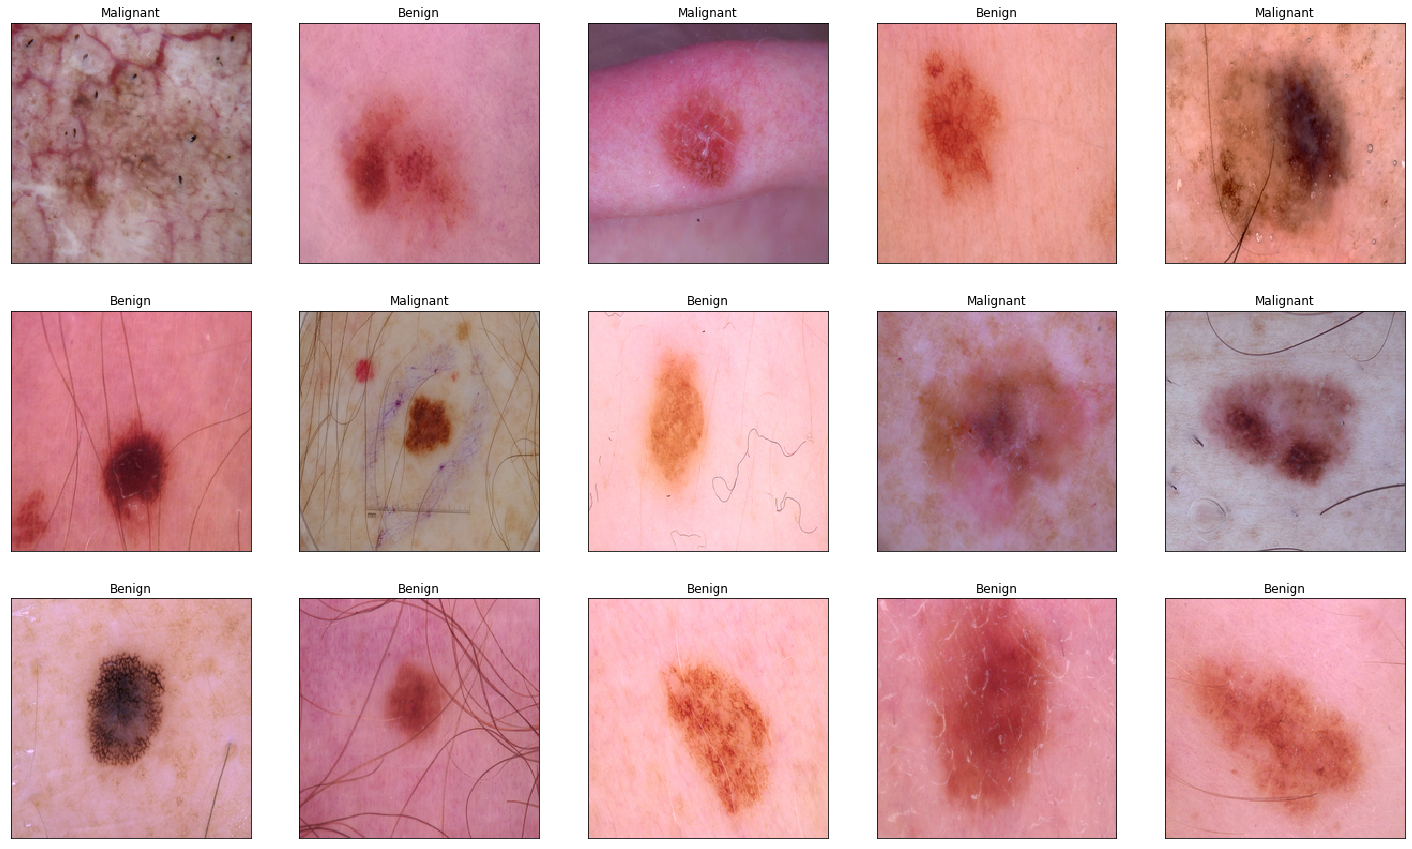

In [18]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(25,15))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [19]:
model=Sequential()

model.add(Conv2D(32,3, activation='relu', input_shape=(IMG_DIMEN, IMG_DIMEN, N_COLORS)))
model.add(MaxPooling2D(2))
model.add(Conv2D(64,3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256,3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       147712    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 256)      0

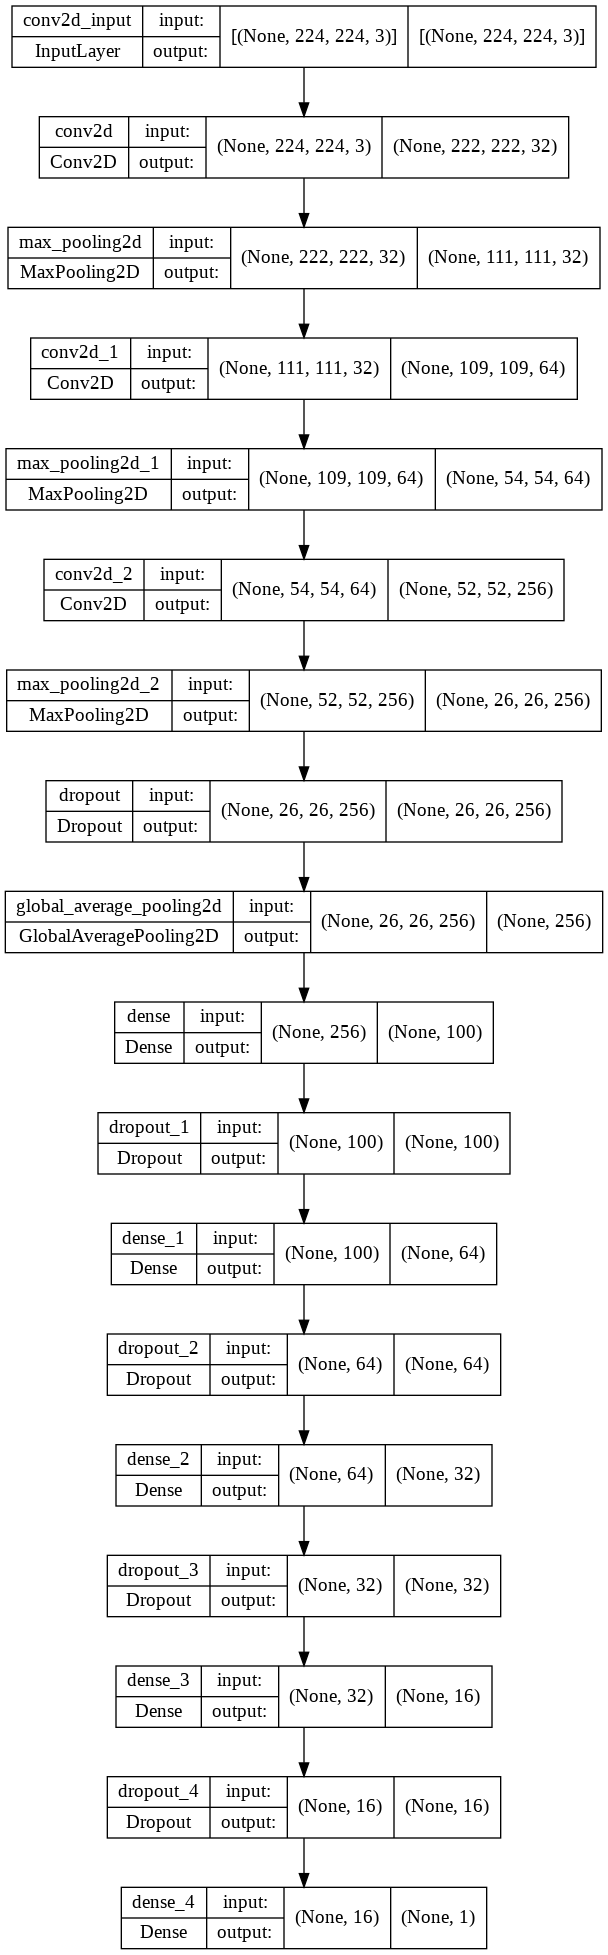

In [20]:
tf.keras.utils.plot_model( model, show_shapes=True )

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'saved-model/best-model', monitor='val_loss', mode='min', 
    save_weights_only=True, save_best_only=True, verbose=1
)


In [23]:
epochs = 120
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint]
)

Epoch 1/120
56/56 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.5674
Epoch 1: val_loss improved from inf to 0.68749, saving model to saved-model/best-model
56/56 [==============================] - 19s 106ms/step - loss: 0.6713 - accuracy: 0.5674 - val_loss: 0.6875 - val_accuracy: 0.5568
Epoch 2/120
55/56 [============================>.] - ETA: 0s - loss: 0.5917 - accuracy: 0.6920
Epoch 2: val_loss improved from 0.68749 to 0.52461, saving model to saved-model/best-model
56/56 [==============================] - 5s 82ms/step - loss: 0.5909 - accuracy: 0.6925 - val_loss: 0.5246 - val_accuracy: 0.7451
Epoch 3/120
55/56 [============================>.] - ETA: 0s - loss: 0.5892 - accuracy: 0.7119
Epoch 3: val_loss did not improve from 0.52461
56/56 [==============================] - 4s 80ms/step - loss: 0.5884 - accuracy: 0.7123 - val_loss: 0.5647 - val_accuracy: 0.7130
Epoch 4/120
55/56 [============================>.] - ETA: 0s - loss: 0.4995 - accuracy: 0.7636
Epo

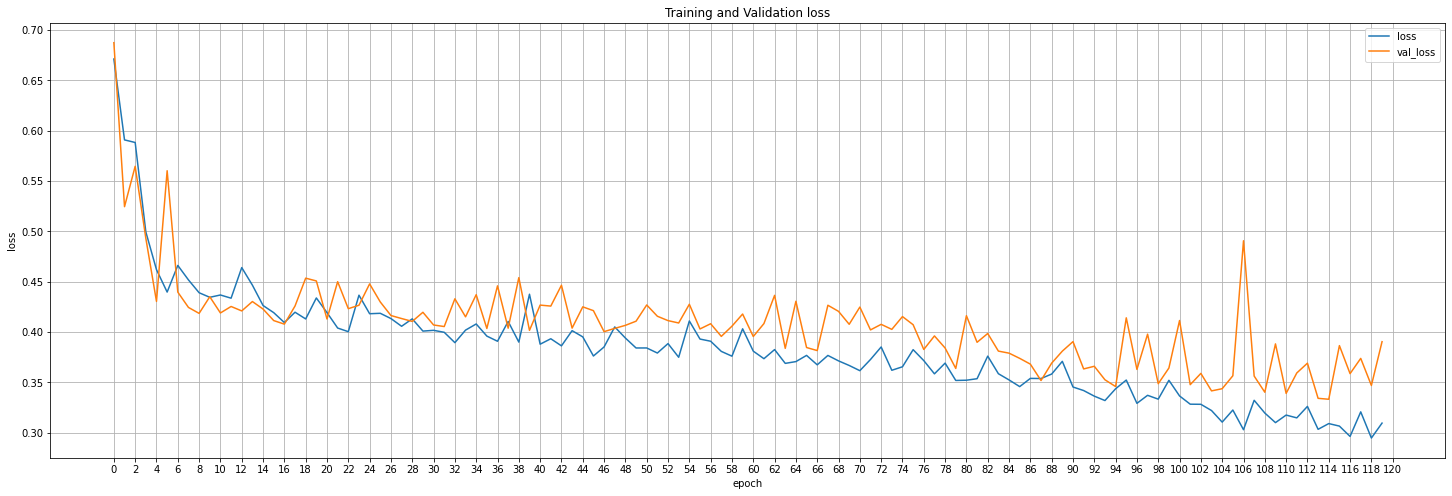

In [24]:

hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['loss', 'val_loss'], figsize=(25, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.grid(axis='both')
plt.xticks(np.arange(0, 121, 2))
plt.show()

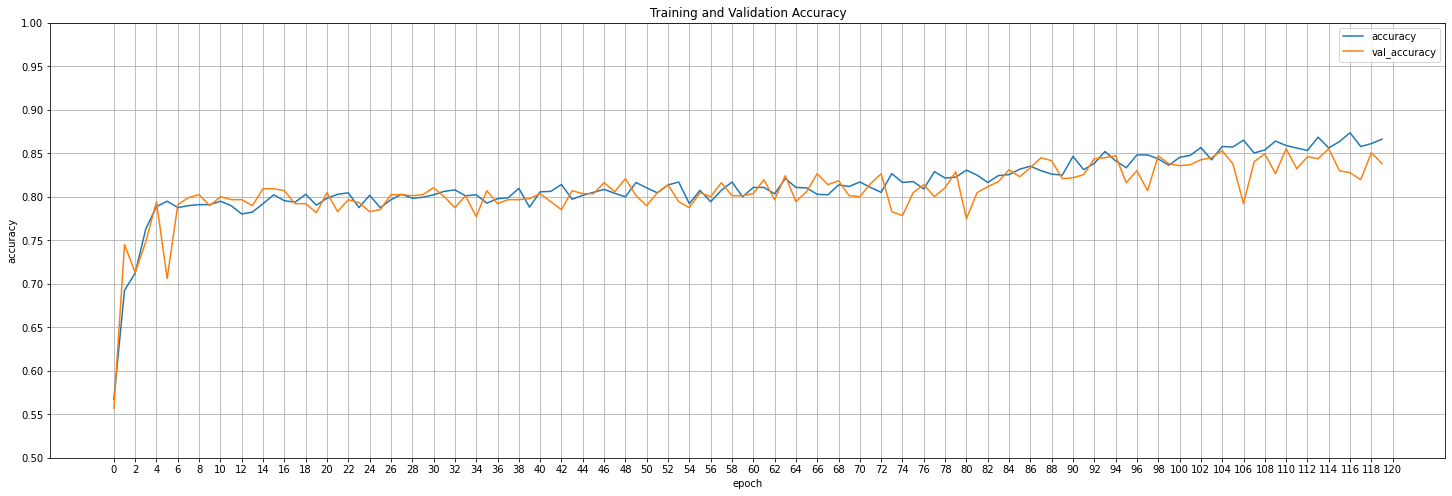

In [25]:
hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['accuracy', 'val_accuracy'], figsize=(25, 8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis='both')
plt.xticks(np.arange(0, 121, 2))
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.show()

In [27]:
model.load_weights('saved-model/best-model')
fianl_loss,finla_acc=model.evaluate(X_test, y_test)

21/21 [==============================] - 1s 42ms/step - loss: 0.3106 - accuracy: 0.8424


In [28]:
print("The Final loss = ",fianl_loss)
print("The Final accurse = ",round(finla_acc,2)*100,"%")

The Final loss =  0.3105839490890503
The Final accurse =  84.0 %
